In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
!apt-get -qq install -y libarchive-dev


In [ ]:
!apt-get -qq install -y libarchive-dev
!pip install libarchive-c


In [ ]:
import libarchive


In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('darkgrid')


import os
from keras.applications import xception
from keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import cv2
from scipy.stats import uniform

from tqdm import tqdm
from glob import glob


from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Masking
from keras.utils import to_categorical

import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint



from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



In [ ]:
keras.applications.Xception(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

91884032/91884032 [==============================] - 1s 0us/step


In [ ]:
# Copying the pretrained models to the cache directory
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Specify the correct file path for Xception models
xception_model_path = '../input/keras-pretrained-models/xception*'

# Copy the Xception models to the cache directory
!cp {xception_model_path} ~/.keras/models/

# Show the copied models
!ls ~/.keras/models


cp: cannot stat '../input/keras-pretrained-models/xception*': No such file or directory
xception_weights_tf_dim_ordering_tf_kernels.h5


In [ ]:
data_folder = '/drive/MyDrive/COLABNOTEBOOK/ODL/Data/data'
categories = ['with_mask', 'without_mask']
len_categories = len(categories)

In [ ]:
#show number of images per category
for category in categories:
    print('{} {} images'.format(category, len(os.listdir(os.path.join(data_folder, category)))))

with_mask 3725 images
without_mask 3828 images


In [ ]:
train_data = []

for i, category in tqdm(enumerate(categories)):
    class_folder = os.path.join(data_folder, category)
    for path in os.listdir(os.path.join(class_folder)):
        train_data.append(['{}/{}'.format(category, path), category, i])
df = pd.DataFrame(train_data, columns=['filepath', 'class', 'label'])

#reduce the data
SAMPLE_PER_CATEGORY = 500
df = pd.concat([df[df['class'] == i][:SAMPLE_PER_CATEGORY] for i in categories])

print('DATAFRAME SHAPE: ',df.shape)
df.head()

2it [00:00, 13.41it/s]


DATAFRAME SHAPE:  (1000, 3)


,filepath,class,label
0,with_mask/with_mask_3457.jpg,with_mask,0
1,with_mask/with_mask_346.jpg,with_mask,0
2,with_mask/with_mask_3452.jpg,with_mask,0
3,with_mask/with_mask_3450.jpg,with_mask,0
4,with_mask/with_mask_3472.jpg,with_mask,0


In [ ]:
# function to get an image
def read_img(filepath, size):
    img = image.load_img(os.path.join(data_folder, filepath), target_size=size)
    #convert image to array
    img = image.img_to_array(img)
    return img

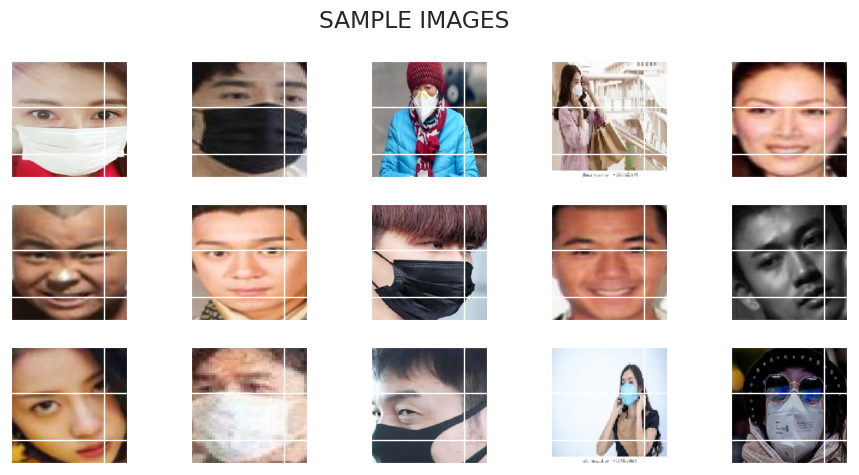

In [ ]:
nb_rows = 3
nb_cols = 5
fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 5));
plt.suptitle('SAMPLE IMAGES');
for i in range(0, nb_rows):
    for j in range(0, nb_cols):
        axs[i, j].xaxis.set_ticklabels([]);
        axs[i, j].yaxis.set_ticklabels([]);
        axs[i, j].imshow((read_img(df['filepath'].iloc[np.random.randint(998)], (255,255)))/255);
plt.show();

In [ ]:
# function to sharpen the images
def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp / 255

In [ ]:
INPUT_SIZE = 255
X_train = np.zeros((len(df), INPUT_SIZE, INPUT_SIZE, 3), dtype='float')

for i, file in tqdm(enumerate(df['filepath'])):
    img_sharpen = sharpen_image(read_img(file, (255,255)))
    X_train[i] = xception.preprocess_input(np.expand_dims(img_sharpen.copy(), axis=0))

1000it [03:44,  4.45it/s]


In [ ]:
print('Train Image Shape: ', X_train.shape)
print('Train Image Size: ', X_train.size)

Train Image Shape:  (1000, 255, 255, 3)
Train Image Size:  195075000


In [ ]:
#split the data
y = df['label']
train_x, train_val, y_train, y_val = train_test_split(X_train, y, test_size=0.2, random_state=101)

In [ ]:
xception_bf = xception.Xception(weights='imagenet', include_top=False, pooling='avg')
bf_train_x = xception_bf.predict(train_x, batch_size=32, verbose=1)
bf_train_val = xception_bf.predict(train_val, batch_size=32, verbose=1)

7/7 [==============================] - 60s 8s/step


In [ ]:
#print shape of feature and size
print('Train Shape: ', bf_train_x.shape)
print('Train Size: ', bf_train_x.size)

print('Validation Shape: ', bf_train_val.shape)
print('Validation Size: ', bf_train_val.size)

Train Shape:  (800, 2048)
Train Size:  1638400
Validation Shape:  (200, 2048)
Validation Size:  409600


In [ ]:
#optimizer
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
opt = keras.optimizers.Adam(learning_rate=lr_schedule)

#keras model
model = Sequential()
model.add(Dense(units = 256 , activation = 'relu', input_dim=bf_train_x.shape[1]))
model.add(Dense(units = 64 , activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))
model.compile(optimizer = opt , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 541057 (2.06 MB)
Trainable params: 541057 (2.06 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#set callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=2),
         ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

#fit the data
history = model.fit(bf_train_x, y_train, batch_size=32, epochs=500, callbacks=callbacks)

Epoch 1/500
25/25 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5375

25/25 [==============================] - 2s 17ms/step - loss: 0.6909 - accuracy: 0.5375
Epoch 2/500
25/25 [==============================] - ETA: 0s - loss: 0.6599 - accuracy: 0.5950

25/25 [==============================] - 0s 16ms/step - loss: 0.6599 - accuracy: 0.5950
Epoch 3/500
25/25 [==============================] - ETA: 0s - loss: 0.6275 - accuracy: 0.6388

25/25 [==============================] - 0s 16ms/step - loss: 0.6275 - accuracy: 0.6388
Epoch 4/500
22/25 [=========================>....] - ETA: 0s - loss: 0.5976 - accuracy: 0.6861

25/25 [==============================] - 0s 16ms/step - loss: 0.5967 - accuracy: 0.6875
Epoch 5/500
25/25 [==============================] - ETA: 0s - loss: 0.5644 - accuracy: 0.7375

25/25 [==============================] - 0s 16ms/step - loss: 0.5644 - accuracy: 0.7375
Epoch 6/500
24/25 [===========================>..] - ETA: 0s - loss: 0.5154 - accuracy: 0.7591

25/25 [==============================] - 0s 15ms/step - loss: 0.5126 - accuracy: 0.7613
Epoch 7/500
23/25 [==========================>...] - ETA: 0s - loss: 0.4790 - accuracy: 0.7772

25/25 [==============================] - 0s 17ms/step - loss: 0.4788 - accuracy: 0.7788
Epoch 8/500
23/25 [==========================>...] - ETA: 0s - loss: 0.4367 - accuracy: 0.8207

25/25 [==============================] - 0s 16ms/step - loss: 0.4461 - accuracy: 0.8062
Epoch 9/500
25/25 [==============================] - ETA: 0s - loss: 0.4195 - accuracy: 0.8325

25/25 [==============================] - 0s 15ms/step - loss: 0.4195 - accuracy: 0.8325
Epoch 10/500
21/25 [========================>.....] - ETA: 0s - loss: 0.3938 - accuracy: 0.8214

25/25 [==============================] - 0s 15ms/step - loss: 0.3931 - accuracy: 0.8275
Epoch 11/500
22/25 [=========================>....] - ETA: 0s - loss: 0.3729 - accuracy: 0.8452

25/25 [==============================] - 0s 14ms/step - loss: 0.3600 - accuracy: 0.8487
Epoch 12/500
20/25 [=======================>......] - ETA: 0s - loss: 0.3586 - accuracy: 0.8438

25/25 [==============================] - 0s 9ms/step - loss: 0.3626 - accuracy: 0.8388
Epoch 13/500
22/25 [=========================>....] - ETA: 0s - loss: 0.3224 - accuracy: 0.8707

25/25 [==============================] - 0s 8ms/step - loss: 0.3249 - accuracy: 0.8687
Epoch 14/500
20/25 [=======================>......] - ETA: 0s - loss: 0.3287 - accuracy: 0.8672

25/25 [==============================] - 0s 9ms/step - loss: 0.3160 - accuracy: 0.8737
Epoch 15/500
22/25 [=========================>....] - ETA: 0s - loss: 0.3141 - accuracy: 0.8821

25/25 [==============================] - 0s 8ms/step - loss: 0.3067 - accuracy: 0.8788
Epoch 16/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2998 - accuracy: 0.8736

25/25 [==============================] - 0s 8ms/step - loss: 0.2968 - accuracy: 0.8750
Epoch 17/500
20/25 [=======================>......] - ETA: 0s - loss: 0.2885 - accuracy: 0.8828

25/25 [==============================] - 0s 9ms/step - loss: 0.2774 - accuracy: 0.8888
Epoch 18/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2752 - accuracy: 0.8949

25/25 [==============================] - 0s 8ms/step - loss: 0.2779 - accuracy: 0.8913
Epoch 19/500
20/25 [=======================>......] - ETA: 0s - loss: 0.3233 - accuracy: 0.8594

25/25 [==============================] - 0s 9ms/step - loss: 0.3099 - accuracy: 0.8687
Epoch 20/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2928 - accuracy: 0.8884

25/25 [==============================] - 0s 8ms/step - loss: 0.2896 - accuracy: 0.8838
Epoch 21/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2741 - accuracy: 0.9034

25/25 [==============================] - 0s 8ms/step - loss: 0.2686 - accuracy: 0.9038
Epoch 22/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2582 - accuracy: 0.9107

25/25 [==============================] - 0s 8ms/step - loss: 0.2559 - accuracy: 0.9100
Epoch 23/500
25/25 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8850

25/25 [==============================] - 0s 10ms/step - loss: 0.2800 - accuracy: 0.8850
Epoch 24/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2421 - accuracy: 0.9062

25/25 [==============================] - 0s 11ms/step - loss: 0.2397 - accuracy: 0.9075
Epoch 25/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2314 - accuracy: 0.9091

25/25 [==============================] - 0s 11ms/step - loss: 0.2453 - accuracy: 0.9013
Epoch 26/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2532 - accuracy: 0.8892

25/25 [==============================] - 0s 11ms/step - loss: 0.2557 - accuracy: 0.8900
Epoch 27/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2764 - accuracy: 0.8864

25/25 [==============================] - 0s 9ms/step - loss: 0.2729 - accuracy: 0.8888
Epoch 28/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2275 - accuracy: 0.9152

25/25 [==============================] - 0s 8ms/step - loss: 0.2559 - accuracy: 0.9050
Epoch 29/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2256 - accuracy: 0.9148

25/25 [==============================] - 0s 8ms/step - loss: 0.2267 - accuracy: 0.9150
Epoch 30/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2257 - accuracy: 0.9205

25/25 [==============================] - 0s 8ms/step - loss: 0.2250 - accuracy: 0.9187
Epoch 31/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2354 - accuracy: 0.9091

25/25 [==============================] - 0s 8ms/step - loss: 0.2420 - accuracy: 0.9050
Epoch 32/500
20/25 [=======================>......] - ETA: 0s - loss: 0.2948 - accuracy: 0.8703

25/25 [==============================] - 0s 11ms/step - loss: 0.2795 - accuracy: 0.8788
Epoch 33/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2151 - accuracy: 0.9219

25/25 [==============================] - 0s 11ms/step - loss: 0.2100 - accuracy: 0.9212
Epoch 34/500
23/25 [==========================>...] - ETA: 0s - loss: 0.2293 - accuracy: 0.9144

25/25 [==============================] - 0s 10ms/step - loss: 0.2373 - accuracy: 0.9112
Epoch 35/500
25/25 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.9062

25/25 [==============================] - 0s 9ms/step - loss: 0.2261 - accuracy: 0.9062
Epoch 36/500
19/25 [=====================>........] - ETA: 0s - loss: 0.2462 - accuracy: 0.8980

25/25 [==============================] - 0s 9ms/step - loss: 0.2324 - accuracy: 0.9062
Epoch 37/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2023 - accuracy: 0.9286

25/25 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.9200
Epoch 38/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2133 - accuracy: 0.9196

25/25 [==============================] - 0s 9ms/step - loss: 0.2103 - accuracy: 0.9225
Epoch 39/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2199 - accuracy: 0.9062

25/25 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.9112
Epoch 40/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1981 - accuracy: 0.9233

25/25 [==============================] - 0s 8ms/step - loss: 0.2037 - accuracy: 0.9225
Epoch 41/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2007 - accuracy: 0.9226

25/25 [==============================] - 0s 8ms/step - loss: 0.2296 - accuracy: 0.9062
Epoch 42/500
21/25 [========================>.....] - ETA: 0s - loss: 0.3022 - accuracy: 0.8735

25/25 [==============================] - 0s 8ms/step - loss: 0.2955 - accuracy: 0.8788
Epoch 43/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2079 - accuracy: 0.9219

25/25 [==============================] - 0s 8ms/step - loss: 0.2122 - accuracy: 0.9187
Epoch 44/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1878 - accuracy: 0.9304

25/25 [==============================] - 0s 8ms/step - loss: 0.2084 - accuracy: 0.9237
Epoch 45/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2143 - accuracy: 0.9190

25/25 [==============================] - 0s 8ms/step - loss: 0.2115 - accuracy: 0.9200
Epoch 46/500
20/25 [=======================>......] - ETA: 0s - loss: 0.2083 - accuracy: 0.9187

25/25 [==============================] - 0s 9ms/step - loss: 0.2117 - accuracy: 0.9175
Epoch 47/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1920 - accuracy: 0.9211

25/25 [==============================] - 0s 9ms/step - loss: 0.1946 - accuracy: 0.9237
Epoch 48/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1960 - accuracy: 0.9304

25/25 [==============================] - 0s 8ms/step - loss: 0.2012 - accuracy: 0.9262
Epoch 49/500
25/25 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9300

25/25 [==============================] - 0s 9ms/step - loss: 0.1778 - accuracy: 0.9300
Epoch 50/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1848 - accuracy: 0.9266

25/25 [==============================] - 0s 11ms/step - loss: 0.1933 - accuracy: 0.9237
Epoch 51/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1839 - accuracy: 0.9297

25/25 [==============================] - 0s 10ms/step - loss: 0.1805 - accuracy: 0.9312
Epoch 52/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1756 - accuracy: 0.9401

25/25 [==============================] - 0s 10ms/step - loss: 0.1738 - accuracy: 0.9413
Epoch 53/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1966 - accuracy: 0.9187

25/25 [==============================] - 0s 9ms/step - loss: 0.2012 - accuracy: 0.9137
Epoch 54/500
25/25 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9150

25/25 [==============================] - 0s 9ms/step - loss: 0.2061 - accuracy: 0.9150
Epoch 55/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1680 - accuracy: 0.9390

25/25 [==============================] - 0s 12ms/step - loss: 0.1687 - accuracy: 0.9400
Epoch 56/500
21/25 [========================>.....] - ETA: 0s - loss: 0.2065 - accuracy: 0.9196

25/25 [==============================] - 0s 12ms/step - loss: 0.2075 - accuracy: 0.9162
Epoch 57/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1666 - accuracy: 0.9375

25/25 [==============================] - 0s 16ms/step - loss: 0.1649 - accuracy: 0.9375
Epoch 58/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1897 - accuracy: 0.9321

25/25 [==============================] - 0s 16ms/step - loss: 0.1831 - accuracy: 0.9337
Epoch 59/500
24/25 [===========================>..] - ETA: 0s - loss: 0.2028 - accuracy: 0.9128

25/25 [==============================] - 0s 15ms/step - loss: 0.2000 - accuracy: 0.9150
Epoch 60/500
24/25 [===========================>..] - ETA: 0s - loss: 0.2052 - accuracy: 0.9167

25/25 [==============================] - 0s 13ms/step - loss: 0.1998 - accuracy: 0.9200
Epoch 61/500
25/25 [==============================] - ETA: 0s - loss: 0.1685 - accuracy: 0.9350

25/25 [==============================] - 0s 12ms/step - loss: 0.1685 - accuracy: 0.9350
Epoch 62/500
25/25 [==============================] - ETA: 0s - loss: 0.1678 - accuracy: 0.9337

25/25 [==============================] - 0s 12ms/step - loss: 0.1678 - accuracy: 0.9337
Epoch 63/500
25/25 [==============================] - ETA: 0s - loss: 0.1510 - accuracy: 0.9450

25/25 [==============================] - 0s 12ms/step - loss: 0.1510 - accuracy: 0.9450
Epoch 64/500
25/25 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.9388

25/25 [==============================] - 0s 12ms/step - loss: 0.1541 - accuracy: 0.9388
Epoch 65/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1640 - accuracy: 0.9315

25/25 [==============================] - 0s 11ms/step - loss: 0.1571 - accuracy: 0.9375
Epoch 66/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1600 - accuracy: 0.9332

25/25 [==============================] - 0s 15ms/step - loss: 0.1539 - accuracy: 0.9388
Epoch 67/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1588 - accuracy: 0.9401

25/25 [==============================] - 0s 15ms/step - loss: 0.1567 - accuracy: 0.9413
Epoch 68/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1510 - accuracy: 0.9466

25/25 [==============================] - 0s 15ms/step - loss: 0.1510 - accuracy: 0.9463
Epoch 69/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1590 - accuracy: 0.9375

25/25 [==============================] - 0s 14ms/step - loss: 0.1564 - accuracy: 0.9400
Epoch 70/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1601 - accuracy: 0.9438

25/25 [==============================] - 0s 9ms/step - loss: 0.1495 - accuracy: 0.9475
Epoch 71/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1633 - accuracy: 0.9389

25/25 [==============================] - 0s 8ms/step - loss: 0.1799 - accuracy: 0.9287
Epoch 72/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2898 - accuracy: 0.8707

25/25 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.8675
Epoch 73/500
25/25 [==============================] - ETA: 0s - loss: 0.2000 - accuracy: 0.9250

25/25 [==============================] - 0s 10ms/step - loss: 0.2000 - accuracy: 0.9250
Epoch 74/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1938 - accuracy: 0.9232

25/25 [==============================] - 0s 11ms/step - loss: 0.1917 - accuracy: 0.9237
Epoch 75/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1999 - accuracy: 0.9232

25/25 [==============================] - 0s 10ms/step - loss: 0.1959 - accuracy: 0.9250
Epoch 76/500
19/25 [=====================>........] - ETA: 0s - loss: 0.1979 - accuracy: 0.9194

25/25 [==============================] - 0s 9ms/step - loss: 0.1885 - accuracy: 0.9262
Epoch 77/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1582 - accuracy: 0.9390

25/25 [==============================] - 0s 8ms/step - loss: 0.1583 - accuracy: 0.9400
Epoch 78/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1448 - accuracy: 0.9509

25/25 [==============================] - 0s 9ms/step - loss: 0.1451 - accuracy: 0.9500
Epoch 79/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1526 - accuracy: 0.9438

25/25 [==============================] - 0s 9ms/step - loss: 0.1585 - accuracy: 0.9425
Epoch 80/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1352 - accuracy: 0.9531

25/25 [==============================] - 0s 8ms/step - loss: 0.1508 - accuracy: 0.9400
Epoch 81/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1414 - accuracy: 0.9460

25/25 [==============================] - 0s 8ms/step - loss: 0.1415 - accuracy: 0.9488
Epoch 82/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1421 - accuracy: 0.9494

25/25 [==============================] - 0s 9ms/step - loss: 0.1377 - accuracy: 0.9488
Epoch 83/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1516 - accuracy: 0.9464

25/25 [==============================] - 0s 9ms/step - loss: 0.1456 - accuracy: 0.9488
Epoch 84/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1341 - accuracy: 0.9539

25/25 [==============================] - 0s 8ms/step - loss: 0.1341 - accuracy: 0.9525
Epoch 85/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1339 - accuracy: 0.9494

25/25 [==============================] - 0s 9ms/step - loss: 0.1445 - accuracy: 0.9425
Epoch 86/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1384 - accuracy: 0.9470

25/25 [==============================] - 0s 10ms/step - loss: 0.1481 - accuracy: 0.9450
Epoch 87/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1536 - accuracy: 0.9361

25/25 [==============================] - 0s 11ms/step - loss: 0.1476 - accuracy: 0.9388
Epoch 88/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1694 - accuracy: 0.9349

25/25 [==============================] - 0s 12ms/step - loss: 0.1710 - accuracy: 0.9350
Epoch 89/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1306 - accuracy: 0.9598

25/25 [==============================] - 0s 11ms/step - loss: 0.1398 - accuracy: 0.9550
Epoch 90/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1432 - accuracy: 0.9418

25/25 [==============================] - 0s 11ms/step - loss: 0.1375 - accuracy: 0.9450
Epoch 91/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1274 - accuracy: 0.9516

25/25 [==============================] - 0s 11ms/step - loss: 0.1375 - accuracy: 0.9463
Epoch 92/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1512 - accuracy: 0.9416

25/25 [==============================] - 0s 10ms/step - loss: 0.1490 - accuracy: 0.9425
Epoch 93/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1887 - accuracy: 0.9152

25/25 [==============================] - 0s 9ms/step - loss: 0.1869 - accuracy: 0.9187
Epoch 94/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1425 - accuracy: 0.9406

25/25 [==============================] - 0s 9ms/step - loss: 0.1411 - accuracy: 0.9438
Epoch 95/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1129 - accuracy: 0.9616

25/25 [==============================] - 0s 9ms/step - loss: 0.1303 - accuracy: 0.9563
Epoch 96/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1395 - accuracy: 0.9469

25/25 [==============================] - 0s 9ms/step - loss: 0.1431 - accuracy: 0.9425
Epoch 97/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1766 - accuracy: 0.9226

25/25 [==============================] - 0s 9ms/step - loss: 0.1792 - accuracy: 0.9225
Epoch 98/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1264 - accuracy: 0.9524

25/25 [==============================] - 0s 8ms/step - loss: 0.1244 - accuracy: 0.9550
Epoch 99/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1407 - accuracy: 0.9432

25/25 [==============================] - 0s 8ms/step - loss: 0.1382 - accuracy: 0.9463
Epoch 100/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1371 - accuracy: 0.9449

25/25 [==============================] - 0s 8ms/step - loss: 0.1525 - accuracy: 0.9388
Epoch 101/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1271 - accuracy: 0.9517

25/25 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.9475
Epoch 102/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1950 - accuracy: 0.9105

25/25 [==============================] - 0s 8ms/step - loss: 0.1957 - accuracy: 0.9137
Epoch 103/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1511 - accuracy: 0.9389

25/25 [==============================] - 0s 8ms/step - loss: 0.1542 - accuracy: 0.9375
Epoch 104/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1433 - accuracy: 0.9474

25/25 [==============================] - 0s 8ms/step - loss: 0.1352 - accuracy: 0.9513
Epoch 105/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1479 - accuracy: 0.9312

25/25 [==============================] - 0s 9ms/step - loss: 0.1647 - accuracy: 0.9287
Epoch 106/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1379 - accuracy: 0.9446

25/25 [==============================] - 0s 8ms/step - loss: 0.1374 - accuracy: 0.9463
Epoch 107/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1666 - accuracy: 0.9261

25/25 [==============================] - 0s 8ms/step - loss: 0.1598 - accuracy: 0.9300
Epoch 108/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1328 - accuracy: 0.9489

25/25 [==============================] - 0s 8ms/step - loss: 0.1261 - accuracy: 0.9513
Epoch 109/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1456 - accuracy: 0.9464

25/25 [==============================] - 0s 8ms/step - loss: 0.1367 - accuracy: 0.9500
Epoch 110/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1125 - accuracy: 0.9594

25/25 [==============================] - 0s 9ms/step - loss: 0.1131 - accuracy: 0.9575
Epoch 111/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1637 - accuracy: 0.9271

25/25 [==============================] - 0s 8ms/step - loss: 0.1687 - accuracy: 0.9250
Epoch 112/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1340 - accuracy: 0.9554

25/25 [==============================] - 0s 12ms/step - loss: 0.1293 - accuracy: 0.9525
Epoch 113/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1354 - accuracy: 0.9539

25/25 [==============================] - 0s 12ms/step - loss: 0.1285 - accuracy: 0.9538
Epoch 114/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1389 - accuracy: 0.9466

25/25 [==============================] - 0s 13ms/step - loss: 0.1347 - accuracy: 0.9488
Epoch 115/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1314 - accuracy: 0.9492

25/25 [==============================] - 0s 15ms/step - loss: 0.1278 - accuracy: 0.9513
Epoch 116/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1479 - accuracy: 0.9362

25/25 [==============================] - 0s 15ms/step - loss: 0.1468 - accuracy: 0.9362
Epoch 117/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1665 - accuracy: 0.9388

25/25 [==============================] - 0s 18ms/step - loss: 0.1655 - accuracy: 0.9400
Epoch 118/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1144 - accuracy: 0.9583

25/25 [==============================] - 0s 15ms/step - loss: 0.1133 - accuracy: 0.9588
Epoch 119/500
25/25 [==============================] - ETA: 0s - loss: 0.1202 - accuracy: 0.9575

25/25 [==============================] - 0s 15ms/step - loss: 0.1202 - accuracy: 0.9575
Epoch 120/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1505 - accuracy: 0.9429

25/25 [==============================] - 0s 13ms/step - loss: 0.1499 - accuracy: 0.9413
Epoch 121/500
25/25 [==============================] - ETA: 0s - loss: 0.1055 - accuracy: 0.9638

25/25 [==============================] - 0s 12ms/step - loss: 0.1055 - accuracy: 0.9638
Epoch 122/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0990 - accuracy: 0.9643

25/25 [==============================] - 0s 12ms/step - loss: 0.1094 - accuracy: 0.9613
Epoch 123/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1209 - accuracy: 0.9517

25/25 [==============================] - 0s 14ms/step - loss: 0.1205 - accuracy: 0.9513
Epoch 124/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1060 - accuracy: 0.9583

25/25 [==============================] - 0s 12ms/step - loss: 0.1064 - accuracy: 0.9588
Epoch 125/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1216 - accuracy: 0.9503

25/25 [==============================] - 0s 13ms/step - loss: 0.1299 - accuracy: 0.9463
Epoch 126/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1435 - accuracy: 0.9416

25/25 [==============================] - 0s 13ms/step - loss: 0.1420 - accuracy: 0.9413
Epoch 127/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1335 - accuracy: 0.9422

25/25 [==============================] - 0s 11ms/step - loss: 0.1319 - accuracy: 0.9425
Epoch 128/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1046 - accuracy: 0.9602

25/25 [==============================] - 0s 8ms/step - loss: 0.0991 - accuracy: 0.9638
Epoch 129/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1062 - accuracy: 0.9602

25/25 [==============================] - 0s 9ms/step - loss: 0.1147 - accuracy: 0.9538
Epoch 130/500
19/25 [=====================>........] - ETA: 0s - loss: 0.1443 - accuracy: 0.9391

25/25 [==============================] - 0s 9ms/step - loss: 0.1375 - accuracy: 0.9438
Epoch 131/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1291 - accuracy: 0.9403

25/25 [==============================] - 0s 9ms/step - loss: 0.1279 - accuracy: 0.9413
Epoch 132/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1081 - accuracy: 0.9554

25/25 [==============================] - 0s 9ms/step - loss: 0.0993 - accuracy: 0.9600
Epoch 133/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1424 - accuracy: 0.9453

25/25 [==============================] - 0s 9ms/step - loss: 0.1297 - accuracy: 0.9500
Epoch 134/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1144 - accuracy: 0.9628

25/25 [==============================] - 0s 9ms/step - loss: 0.1104 - accuracy: 0.9625
Epoch 135/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1055 - accuracy: 0.9628

25/25 [==============================] - 0s 8ms/step - loss: 0.1041 - accuracy: 0.9625
Epoch 136/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1268 - accuracy: 0.9432

25/25 [==============================] - 0s 8ms/step - loss: 0.1258 - accuracy: 0.9438
Epoch 137/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1243 - accuracy: 0.9509

25/25 [==============================] - 0s 8ms/step - loss: 0.1228 - accuracy: 0.9525
Epoch 138/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0965 - accuracy: 0.9658

25/25 [==============================] - 0s 8ms/step - loss: 0.1021 - accuracy: 0.9638
Epoch 139/500
25/25 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9613

25/25 [==============================] - 0s 10ms/step - loss: 0.0969 - accuracy: 0.9613
Epoch 140/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0999 - accuracy: 0.9598

25/25 [==============================] - 0s 8ms/step - loss: 0.1014 - accuracy: 0.9588
Epoch 141/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1058 - accuracy: 0.9583

25/25 [==============================] - 0s 8ms/step - loss: 0.1129 - accuracy: 0.9513
Epoch 142/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1528 - accuracy: 0.9261

25/25 [==============================] - 0s 8ms/step - loss: 0.1457 - accuracy: 0.9300
Epoch 143/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1498 - accuracy: 0.9375

25/25 [==============================] - 0s 9ms/step - loss: 0.1572 - accuracy: 0.9337
Epoch 144/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1524 - accuracy: 0.9422

25/25 [==============================] - 0s 9ms/step - loss: 0.1379 - accuracy: 0.9475
Epoch 145/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0874 - accuracy: 0.9673

25/25 [==============================] - 0s 8ms/step - loss: 0.0860 - accuracy: 0.9675
Epoch 146/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0941 - accuracy: 0.9688

25/25 [==============================] - 0s 8ms/step - loss: 0.1005 - accuracy: 0.9650
Epoch 147/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1164 - accuracy: 0.9460

25/25 [==============================] - 0s 8ms/step - loss: 0.1185 - accuracy: 0.9463
Epoch 148/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1275 - accuracy: 0.9531

25/25 [==============================] - 0s 10ms/step - loss: 0.1280 - accuracy: 0.9538
Epoch 149/500
25/25 [==============================] - ETA: 0s - loss: 0.0988 - accuracy: 0.9613

25/25 [==============================] - 0s 10ms/step - loss: 0.0988 - accuracy: 0.9613
Epoch 150/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1680 - accuracy: 0.9334

25/25 [==============================] - 0s 11ms/step - loss: 0.1591 - accuracy: 0.9362
Epoch 151/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1405 - accuracy: 0.9429

25/25 [==============================] - 0s 11ms/step - loss: 0.1365 - accuracy: 0.9463
Epoch 152/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0997 - accuracy: 0.9596

25/25 [==============================] - 0s 10ms/step - loss: 0.0965 - accuracy: 0.9613
Epoch 153/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0901 - accuracy: 0.9688

25/25 [==============================] - 0s 8ms/step - loss: 0.1023 - accuracy: 0.9638
Epoch 154/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0918 - accuracy: 0.9673

25/25 [==============================] - 0s 8ms/step - loss: 0.0923 - accuracy: 0.9663
Epoch 155/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0829 - accuracy: 0.9702

25/25 [==============================] - 0s 8ms/step - loss: 0.0904 - accuracy: 0.9700
Epoch 156/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1437 - accuracy: 0.9360

25/25 [==============================] - 0s 9ms/step - loss: 0.1327 - accuracy: 0.9425
Epoch 157/500
19/25 [=====================>........] - ETA: 0s - loss: 0.1478 - accuracy: 0.9424

25/25 [==============================] - 0s 9ms/step - loss: 0.1389 - accuracy: 0.9475
Epoch 158/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1197 - accuracy: 0.9517

25/25 [==============================] - 0s 8ms/step - loss: 0.1149 - accuracy: 0.9538
Epoch 159/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1276 - accuracy: 0.9479

25/25 [==============================] - 0s 8ms/step - loss: 0.1255 - accuracy: 0.9475
Epoch 160/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0967 - accuracy: 0.9688

25/25 [==============================] - 0s 8ms/step - loss: 0.0967 - accuracy: 0.9675
Epoch 161/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0958 - accuracy: 0.9622

25/25 [==============================] - 0s 10ms/step - loss: 0.0929 - accuracy: 0.9638
Epoch 162/500
25/25 [==============================] - ETA: 0s - loss: 0.1303 - accuracy: 0.9450

25/25 [==============================] - 0s 9ms/step - loss: 0.1303 - accuracy: 0.9450
Epoch 163/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1130 - accuracy: 0.9570

25/25 [==============================] - 0s 10ms/step - loss: 0.1122 - accuracy: 0.9575
Epoch 164/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1188 - accuracy: 0.9497

25/25 [==============================] - 0s 11ms/step - loss: 0.1116 - accuracy: 0.9538
Epoch 165/500
25/25 [==============================] - ETA: 0s - loss: 0.0835 - accuracy: 0.9725

25/25 [==============================] - 0s 9ms/step - loss: 0.0835 - accuracy: 0.9725
Epoch 166/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0911 - accuracy: 0.9673

25/25 [==============================] - 0s 9ms/step - loss: 0.0854 - accuracy: 0.9688
Epoch 167/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0828 - accuracy: 0.9658

25/25 [==============================] - 0s 9ms/step - loss: 0.0745 - accuracy: 0.9712
Epoch 168/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0860 - accuracy: 0.9658

25/25 [==============================] - 0s 9ms/step - loss: 0.0801 - accuracy: 0.9688
Epoch 169/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0915 - accuracy: 0.9631

25/25 [==============================] - 0s 8ms/step - loss: 0.0940 - accuracy: 0.9588
Epoch 170/500
25/25 [==============================] - ETA: 0s - loss: 0.0958 - accuracy: 0.9638

25/25 [==============================] - 0s 15ms/step - loss: 0.0958 - accuracy: 0.9638
Epoch 171/500
25/25 [==============================] - ETA: 0s - loss: 0.0920 - accuracy: 0.9613

25/25 [==============================] - 0s 15ms/step - loss: 0.0920 - accuracy: 0.9613
Epoch 172/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1152 - accuracy: 0.9616

25/25 [==============================] - 0s 14ms/step - loss: 0.1107 - accuracy: 0.9625
Epoch 173/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9762

25/25 [==============================] - 0s 12ms/step - loss: 0.0695 - accuracy: 0.9775
Epoch 174/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0766 - accuracy: 0.9701

25/25 [==============================] - 0s 13ms/step - loss: 0.0761 - accuracy: 0.9688
Epoch 175/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0952 - accuracy: 0.9661

25/25 [==============================] - 0s 13ms/step - loss: 0.0949 - accuracy: 0.9663
Epoch 176/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0897 - accuracy: 0.9648

25/25 [==============================] - 0s 15ms/step - loss: 0.0925 - accuracy: 0.9650
Epoch 177/500
25/25 [==============================] - ETA: 0s - loss: 0.0775 - accuracy: 0.9712

25/25 [==============================] - 0s 15ms/step - loss: 0.0775 - accuracy: 0.9712
Epoch 178/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0720 - accuracy: 0.9715

25/25 [==============================] - 0s 14ms/step - loss: 0.0708 - accuracy: 0.9725
Epoch 179/500
25/25 [==============================] - ETA: 0s - loss: 0.0716 - accuracy: 0.9712

25/25 [==============================] - 0s 12ms/step - loss: 0.0716 - accuracy: 0.9712
Epoch 180/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0695 - accuracy: 0.9740

25/25 [==============================] - 0s 13ms/step - loss: 0.0683 - accuracy: 0.9750
Epoch 181/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0687 - accuracy: 0.9714

25/25 [==============================] - 0s 13ms/step - loss: 0.0709 - accuracy: 0.9712
Epoch 182/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0797 - accuracy: 0.9633

25/25 [==============================] - 0s 16ms/step - loss: 0.0824 - accuracy: 0.9625
Epoch 183/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0881 - accuracy: 0.9674

25/25 [==============================] - 0s 16ms/step - loss: 0.0865 - accuracy: 0.9675
Epoch 184/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0647 - accuracy: 0.9769

25/25 [==============================] - 0s 14ms/step - loss: 0.0619 - accuracy: 0.9787
Epoch 185/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0623 - accuracy: 0.9769

25/25 [==============================] - 0s 13ms/step - loss: 0.0587 - accuracy: 0.9787
Epoch 186/500
25/25 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9800

25/25 [==============================] - 0s 10ms/step - loss: 0.0605 - accuracy: 0.9800
Epoch 187/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0725 - accuracy: 0.9747

25/25 [==============================] - 0s 8ms/step - loss: 0.0668 - accuracy: 0.9762
Epoch 188/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0675 - accuracy: 0.9797

25/25 [==============================] - 0s 9ms/step - loss: 0.0629 - accuracy: 0.9825
Epoch 189/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0684 - accuracy: 0.9730

25/25 [==============================] - 0s 8ms/step - loss: 0.0660 - accuracy: 0.9750
Epoch 190/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0728 - accuracy: 0.9720

25/25 [==============================] - 0s 9ms/step - loss: 0.0723 - accuracy: 0.9737
Epoch 191/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0701 - accuracy: 0.9702

25/25 [==============================] - 0s 8ms/step - loss: 0.0749 - accuracy: 0.9712
Epoch 192/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0840 - accuracy: 0.9598

25/25 [==============================] - 0s 9ms/step - loss: 0.0810 - accuracy: 0.9625
Epoch 193/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0573 - accuracy: 0.9830

25/25 [==============================] - 0s 9ms/step - loss: 0.0628 - accuracy: 0.9800
Epoch 194/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0940 - accuracy: 0.9673

25/25 [==============================] - 0s 9ms/step - loss: 0.0907 - accuracy: 0.9675
Epoch 195/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0607 - accuracy: 0.9770

25/25 [==============================] - 0s 9ms/step - loss: 0.0628 - accuracy: 0.9762
Epoch 196/500
25/25 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9312

25/25 [==============================] - 0s 9ms/step - loss: 0.1723 - accuracy: 0.9312
Epoch 197/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0649 - accuracy: 0.9755

25/25 [==============================] - 0s 10ms/step - loss: 0.0684 - accuracy: 0.9737
Epoch 198/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0793 - accuracy: 0.9688

25/25 [==============================] - 0s 11ms/step - loss: 0.0796 - accuracy: 0.9700
Epoch 199/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0517 - accuracy: 0.9830

25/25 [==============================] - 0s 11ms/step - loss: 0.0627 - accuracy: 0.9775
Epoch 200/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0952 - accuracy: 0.9598

25/25 [==============================] - 0s 11ms/step - loss: 0.0901 - accuracy: 0.9625
Epoch 201/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0675 - accuracy: 0.9716

25/25 [==============================] - 0s 12ms/step - loss: 0.0677 - accuracy: 0.9725
Epoch 202/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0982 - accuracy: 0.9554

25/25 [==============================] - 0s 11ms/step - loss: 0.0915 - accuracy: 0.9588
Epoch 203/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0924 - accuracy: 0.9570

25/25 [==============================] - 0s 10ms/step - loss: 0.0932 - accuracy: 0.9575
Epoch 204/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0883 - accuracy: 0.9688

25/25 [==============================] - 0s 11ms/step - loss: 0.0861 - accuracy: 0.9700
Epoch 205/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0573 - accuracy: 0.9821

25/25 [==============================] - 0s 11ms/step - loss: 0.0632 - accuracy: 0.9762
Epoch 206/500
25/25 [==============================] - ETA: 0s - loss: 0.0871 - accuracy: 0.9650

25/25 [==============================] - 0s 12ms/step - loss: 0.0871 - accuracy: 0.9650
Epoch 207/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0614 - accuracy: 0.9779

25/25 [==============================] - 0s 11ms/step - loss: 0.0626 - accuracy: 0.9775
Epoch 208/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0739 - accuracy: 0.9702

25/25 [==============================] - 0s 10ms/step - loss: 0.0732 - accuracy: 0.9712
Epoch 209/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0581 - accuracy: 0.9769

25/25 [==============================] - 0s 10ms/step - loss: 0.0560 - accuracy: 0.9787
Epoch 210/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1726 - accuracy: 0.9315

25/25 [==============================] - 0s 11ms/step - loss: 0.1600 - accuracy: 0.9362
Epoch 211/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0600 - accuracy: 0.9792

25/25 [==============================] - 0s 11ms/step - loss: 0.0608 - accuracy: 0.9762
Epoch 212/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0486 - accuracy: 0.9872

25/25 [==============================] - 0s 11ms/step - loss: 0.0599 - accuracy: 0.9787
Epoch 213/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0927 - accuracy: 0.9557

25/25 [==============================] - 0s 12ms/step - loss: 0.0917 - accuracy: 0.9575
Epoch 214/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1196 - accuracy: 0.9531

25/25 [==============================] - 0s 11ms/step - loss: 0.1143 - accuracy: 0.9563
Epoch 215/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0633 - accuracy: 0.9792

25/25 [==============================] - 0s 11ms/step - loss: 0.0622 - accuracy: 0.9800
Epoch 216/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0495 - accuracy: 0.9812

25/25 [==============================] - 0s 11ms/step - loss: 0.0477 - accuracy: 0.9825
Epoch 217/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0436 - accuracy: 0.9866

25/25 [==============================] - 0s 11ms/step - loss: 0.0496 - accuracy: 0.9850
Epoch 218/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0519 - accuracy: 0.9801

25/25 [==============================] - 0s 10ms/step - loss: 0.0490 - accuracy: 0.9800
Epoch 219/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0956 - accuracy: 0.9658

25/25 [==============================] - 0s 11ms/step - loss: 0.0882 - accuracy: 0.9700
Epoch 220/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0633 - accuracy: 0.9783

25/25 [==============================] - 0s 11ms/step - loss: 0.0625 - accuracy: 0.9787
Epoch 221/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0482 - accuracy: 0.9792

25/25 [==============================] - 0s 12ms/step - loss: 0.0453 - accuracy: 0.9812
Epoch 222/500
25/25 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9712

25/25 [==============================] - 0s 11ms/step - loss: 0.0627 - accuracy: 0.9712
Epoch 223/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0480 - accuracy: 0.9883

25/25 [==============================] - 0s 15ms/step - loss: 0.0463 - accuracy: 0.9887
Epoch 224/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0491 - accuracy: 0.9831

25/25 [==============================] - 0s 15ms/step - loss: 0.0483 - accuracy: 0.9837
Epoch 225/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0433 - accuracy: 0.9881

25/25 [==============================] - 0s 11ms/step - loss: 0.0522 - accuracy: 0.9837
Epoch 226/500
25/25 [==============================] - ETA: 0s - loss: 0.0562 - accuracy: 0.9812

25/25 [==============================] - 0s 12ms/step - loss: 0.0562 - accuracy: 0.9812
Epoch 227/500
25/25 [==============================] - ETA: 0s - loss: 0.0563 - accuracy: 0.9775

25/25 [==============================] - 0s 12ms/step - loss: 0.0563 - accuracy: 0.9775
Epoch 228/500
25/25 [==============================] - ETA: 0s - loss: 0.0473 - accuracy: 0.9862

25/25 [==============================] - 0s 15ms/step - loss: 0.0473 - accuracy: 0.9862
Epoch 229/500
25/25 [==============================] - ETA: 0s - loss: 0.0418 - accuracy: 0.9862

25/25 [==============================] - 0s 15ms/step - loss: 0.0418 - accuracy: 0.9862
Epoch 230/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0568 - accuracy: 0.9783

25/25 [==============================] - 0s 15ms/step - loss: 0.0611 - accuracy: 0.9762
Epoch 231/500
25/25 [==============================] - ETA: 0s - loss: 0.0684 - accuracy: 0.9737

25/25 [==============================] - 0s 12ms/step - loss: 0.0684 - accuracy: 0.9737
Epoch 232/500
25/25 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9787

25/25 [==============================] - 0s 12ms/step - loss: 0.0638 - accuracy: 0.9787
Epoch 233/500
25/25 [==============================] - ETA: 0s - loss: 0.0609 - accuracy: 0.9737

25/25 [==============================] - 0s 12ms/step - loss: 0.0609 - accuracy: 0.9737
Epoch 234/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0563 - accuracy: 0.9769

25/25 [==============================] - 0s 16ms/step - loss: 0.0575 - accuracy: 0.9775
Epoch 235/500
25/25 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9887

25/25 [==============================] - 0s 15ms/step - loss: 0.0404 - accuracy: 0.9887
Epoch 236/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0553 - accuracy: 0.9787

25/25 [==============================] - 0s 14ms/step - loss: 0.0616 - accuracy: 0.9762
Epoch 237/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0536 - accuracy: 0.9810

25/25 [==============================] - 0s 14ms/step - loss: 0.0514 - accuracy: 0.9825
Epoch 238/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0406 - accuracy: 0.9901

25/25 [==============================] - 0s 14ms/step - loss: 0.0399 - accuracy: 0.9900
Epoch 239/500
25/25 [==============================] - ETA: 0s - loss: 0.0622 - accuracy: 0.9762

25/25 [==============================] - 0s 15ms/step - loss: 0.0622 - accuracy: 0.9762
Epoch 240/500
25/25 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9762

25/25 [==============================] - 0s 17ms/step - loss: 0.0664 - accuracy: 0.9762
Epoch 241/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1203 - accuracy: 0.9511

25/25 [==============================] - 0s 11ms/step - loss: 0.1131 - accuracy: 0.9538
Epoch 242/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0613 - accuracy: 0.9715

25/25 [==============================] - 0s 11ms/step - loss: 0.0603 - accuracy: 0.9725
Epoch 243/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0585 - accuracy: 0.9779

25/25 [==============================] - 0s 12ms/step - loss: 0.0594 - accuracy: 0.9775
Epoch 244/500
25/25 [==============================] - ETA: 0s - loss: 0.0620 - accuracy: 0.9787

25/25 [==============================] - 0s 12ms/step - loss: 0.0620 - accuracy: 0.9787
Epoch 245/500
25/25 [==============================] - ETA: 0s - loss: 0.0625 - accuracy: 0.9762

25/25 [==============================] - 0s 11ms/step - loss: 0.0625 - accuracy: 0.9762
Epoch 246/500
25/25 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9825

25/25 [==============================] - 0s 9ms/step - loss: 0.0511 - accuracy: 0.9825
Epoch 247/500
25/25 [==============================] - ETA: 0s - loss: 0.0396 - accuracy: 0.9887

25/25 [==============================] - 0s 9ms/step - loss: 0.0396 - accuracy: 0.9887
Epoch 248/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0444 - accuracy: 0.9866

25/25 [==============================] - 0s 8ms/step - loss: 0.0400 - accuracy: 0.9887
Epoch 249/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0446 - accuracy: 0.9859

25/25 [==============================] - 0s 9ms/step - loss: 0.0567 - accuracy: 0.9787
Epoch 250/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1818 - accuracy: 0.9328

25/25 [==============================] - 0s 8ms/step - loss: 0.1647 - accuracy: 0.9400
Epoch 251/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0552 - accuracy: 0.9762

25/25 [==============================] - 0s 9ms/step - loss: 0.0560 - accuracy: 0.9787
Epoch 252/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0521 - accuracy: 0.9781

25/25 [==============================] - 0s 9ms/step - loss: 0.0505 - accuracy: 0.9812
Epoch 253/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0403 - accuracy: 0.9875

25/25 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9862
Epoch 254/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0489 - accuracy: 0.9807

25/25 [==============================] - 0s 9ms/step - loss: 0.0470 - accuracy: 0.9837
Epoch 255/500
25/25 [==============================] - ETA: 0s - loss: 0.0441 - accuracy: 0.9862

25/25 [==============================] - 0s 9ms/step - loss: 0.0441 - accuracy: 0.9862
Epoch 256/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0394 - accuracy: 0.9828

25/25 [==============================] - 0s 9ms/step - loss: 0.0359 - accuracy: 0.9862
Epoch 257/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0370 - accuracy: 0.9844

25/25 [==============================] - 0s 9ms/step - loss: 0.0390 - accuracy: 0.9825
Epoch 258/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0462 - accuracy: 0.9866

25/25 [==============================] - 0s 9ms/step - loss: 0.0418 - accuracy: 0.9887
Epoch 259/500
25/25 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9925

25/25 [==============================] - 0s 12ms/step - loss: 0.0311 - accuracy: 0.9925
Epoch 260/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0385 - accuracy: 0.9870

25/25 [==============================] - 0s 12ms/step - loss: 0.0377 - accuracy: 0.9875
Epoch 261/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0349 - accuracy: 0.9896

25/25 [==============================] - 0s 11ms/step - loss: 0.0328 - accuracy: 0.9900
Epoch 262/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0795 - accuracy: 0.9643

25/25 [==============================] - 0s 11ms/step - loss: 0.0943 - accuracy: 0.9588
Epoch 263/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1014 - accuracy: 0.9552

25/25 [==============================] - 0s 11ms/step - loss: 0.1004 - accuracy: 0.9550
Epoch 264/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0965 - accuracy: 0.9631

25/25 [==============================] - 0s 11ms/step - loss: 0.1032 - accuracy: 0.9588
Epoch 265/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0507 - accuracy: 0.9821

25/25 [==============================] - 0s 11ms/step - loss: 0.0515 - accuracy: 0.9825
Epoch 266/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0318 - accuracy: 0.9911

25/25 [==============================] - 0s 9ms/step - loss: 0.0320 - accuracy: 0.9912
Epoch 267/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0314 - accuracy: 0.9881

25/25 [==============================] - 0s 9ms/step - loss: 0.0312 - accuracy: 0.9887
Epoch 268/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0243 - accuracy: 0.9940

25/25 [==============================] - 0s 9ms/step - loss: 0.0373 - accuracy: 0.9875
Epoch 269/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0483 - accuracy: 0.9801

25/25 [==============================] - 0s 9ms/step - loss: 0.0487 - accuracy: 0.9812
Epoch 270/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0377 - accuracy: 0.9905

25/25 [==============================] - 0s 10ms/step - loss: 0.0368 - accuracy: 0.9912
Epoch 271/500
25/25 [==============================] - ETA: 0s - loss: 0.0383 - accuracy: 0.9862

25/25 [==============================] - 0s 12ms/step - loss: 0.0383 - accuracy: 0.9862
Epoch 272/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0609 - accuracy: 0.9744

25/25 [==============================] - 0s 12ms/step - loss: 0.0739 - accuracy: 0.9700
Epoch 273/500
23/25 [==========================>...] - ETA: 0s - loss: 0.1646 - accuracy: 0.9429

25/25 [==============================] - 0s 11ms/step - loss: 0.1589 - accuracy: 0.9450
Epoch 274/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0726 - accuracy: 0.9628

25/25 [==============================] - 0s 11ms/step - loss: 0.0663 - accuracy: 0.9675
Epoch 275/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0343 - accuracy: 0.9905

25/25 [==============================] - 0s 12ms/step - loss: 0.0359 - accuracy: 0.9887
Epoch 276/500
25/25 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9912

25/25 [==============================] - 0s 11ms/step - loss: 0.0285 - accuracy: 0.9912
Epoch 277/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0290 - accuracy: 0.9926

25/25 [==============================] - 0s 11ms/step - loss: 0.0271 - accuracy: 0.9937
Epoch 278/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0273 - accuracy: 0.9935

25/25 [==============================] - 0s 15ms/step - loss: 0.0268 - accuracy: 0.9937
Epoch 279/500
25/25 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9937

25/25 [==============================] - 0s 15ms/step - loss: 0.0302 - accuracy: 0.9937
Epoch 280/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0420 - accuracy: 0.9807

25/25 [==============================] - 0s 12ms/step - loss: 0.0524 - accuracy: 0.9762
Epoch 281/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1004 - accuracy: 0.9583

25/25 [==============================] - 0s 11ms/step - loss: 0.1111 - accuracy: 0.9550
Epoch 282/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1238 - accuracy: 0.9531

25/25 [==============================] - 0s 13ms/step - loss: 0.1261 - accuracy: 0.9538
Epoch 283/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0580 - accuracy: 0.9792

25/25 [==============================] - 0s 12ms/step - loss: 0.0566 - accuracy: 0.9800
Epoch 284/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0372 - accuracy: 0.9922

25/25 [==============================] - 0s 13ms/step - loss: 0.0359 - accuracy: 0.9925
Epoch 285/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0416 - accuracy: 0.9844

25/25 [==============================] - 0s 14ms/step - loss: 0.0403 - accuracy: 0.9850
Epoch 286/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0533 - accuracy: 0.9801

25/25 [==============================] - 0s 14ms/step - loss: 0.0490 - accuracy: 0.9812
Epoch 287/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0299 - accuracy: 0.9940

25/25 [==============================] - 0s 14ms/step - loss: 0.0271 - accuracy: 0.9937
Epoch 288/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0388 - accuracy: 0.9837

25/25 [==============================] - 0s 15ms/step - loss: 0.0373 - accuracy: 0.9850
Epoch 289/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0264 - accuracy: 0.9948

25/25 [==============================] - 0s 16ms/step - loss: 0.0267 - accuracy: 0.9950
Epoch 290/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0306 - accuracy: 0.9896

25/25 [==============================] - 0s 17ms/step - loss: 0.0302 - accuracy: 0.9900
Epoch 291/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0202 - accuracy: 0.9948

25/25 [==============================] - 0s 15ms/step - loss: 0.0252 - accuracy: 0.9937
Epoch 292/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0341 - accuracy: 0.9881

25/25 [==============================] - 0s 12ms/step - loss: 0.0365 - accuracy: 0.9875
Epoch 293/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0314 - accuracy: 0.9883

25/25 [==============================] - 0s 13ms/step - loss: 0.0309 - accuracy: 0.9887
Epoch 294/500
25/25 [==============================] - ETA: 0s - loss: 0.0219 - accuracy: 0.9962

25/25 [==============================] - 0s 14ms/step - loss: 0.0219 - accuracy: 0.9962
Epoch 295/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0279 - accuracy: 0.9943

25/25 [==============================] - 0s 13ms/step - loss: 0.0275 - accuracy: 0.9937
Epoch 296/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0255 - accuracy: 0.9922

25/25 [==============================] - 0s 9ms/step - loss: 0.0321 - accuracy: 0.9900
Epoch 297/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0274 - accuracy: 0.9935

25/25 [==============================] - 0s 10ms/step - loss: 0.0264 - accuracy: 0.9937
Epoch 298/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0220 - accuracy: 0.9959

25/25 [==============================] - 0s 11ms/step - loss: 0.0223 - accuracy: 0.9950
Epoch 299/500
25/25 [==============================] - ETA: 0s - loss: 0.0206 - accuracy: 0.9962

25/25 [==============================] - 0s 11ms/step - loss: 0.0206 - accuracy: 0.9962
Epoch 300/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0200 - accuracy: 0.9972

25/25 [==============================] - 0s 13ms/step - loss: 0.0259 - accuracy: 0.9950
Epoch 301/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0231 - accuracy: 0.9943

25/25 [==============================] - 0s 11ms/step - loss: 0.0289 - accuracy: 0.9925
Epoch 302/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0550 - accuracy: 0.9797

25/25 [==============================] - 0s 9ms/step - loss: 0.0520 - accuracy: 0.9800
Epoch 303/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0681 - accuracy: 0.9766

25/25 [==============================] - 0s 9ms/step - loss: 0.0622 - accuracy: 0.9800
Epoch 304/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0592 - accuracy: 0.9720

25/25 [==============================] - 0s 9ms/step - loss: 0.0497 - accuracy: 0.9787
Epoch 305/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0229 - accuracy: 0.9948

25/25 [==============================] - 0s 10ms/step - loss: 0.0226 - accuracy: 0.9950
Epoch 306/500
25/25 [==============================] - ETA: 0s - loss: 0.0304 - accuracy: 0.9887

25/25 [==============================] - 0s 9ms/step - loss: 0.0304 - accuracy: 0.9887
Epoch 307/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0851 - accuracy: 0.9674

25/25 [==============================] - 0s 10ms/step - loss: 0.0859 - accuracy: 0.9663
Epoch 308/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0624 - accuracy: 0.9755

25/25 [==============================] - 0s 10ms/step - loss: 0.0645 - accuracy: 0.9737
Epoch 309/500
22/25 [=========================>....] - ETA: 0s - loss: 0.1292 - accuracy: 0.9574

25/25 [==============================] - 0s 11ms/step - loss: 0.1162 - accuracy: 0.9625
Epoch 310/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0622 - accuracy: 0.9792

25/25 [==============================] - 0s 11ms/step - loss: 0.0552 - accuracy: 0.9812
Epoch 311/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0308 - accuracy: 0.9926

25/25 [==============================] - 0s 11ms/step - loss: 0.0307 - accuracy: 0.9925
Epoch 312/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0305 - accuracy: 0.9896

25/25 [==============================] - 0s 11ms/step - loss: 0.0303 - accuracy: 0.9900
Epoch 313/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0353 - accuracy: 0.9870

25/25 [==============================] - 0s 12ms/step - loss: 0.0343 - accuracy: 0.9875
Epoch 314/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0632 - accuracy: 0.9702

25/25 [==============================] - 0s 11ms/step - loss: 0.0553 - accuracy: 0.9750
Epoch 315/500
25/25 [==============================] - ETA: 0s - loss: 0.0273 - accuracy: 0.9925

25/25 [==============================] - 0s 11ms/step - loss: 0.0273 - accuracy: 0.9925
Epoch 316/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0244 - accuracy: 0.9929

25/25 [==============================] - 0s 11ms/step - loss: 0.0267 - accuracy: 0.9925
Epoch 317/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0156 - accuracy: 0.9972

25/25 [==============================] - 0s 11ms/step - loss: 0.0189 - accuracy: 0.9962
Epoch 318/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0274 - accuracy: 0.9970

25/25 [==============================] - 0s 11ms/step - loss: 0.0283 - accuracy: 0.9962
Epoch 319/500
25/25 [==============================] - ETA: 0s - loss: 0.0606 - accuracy: 0.9775

25/25 [==============================] - 0s 11ms/step - loss: 0.0606 - accuracy: 0.9775
Epoch 320/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0262 - accuracy: 0.9946

25/25 [==============================] - 0s 13ms/step - loss: 0.0252 - accuracy: 0.9950
Epoch 321/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0334 - accuracy: 0.9864

25/25 [==============================] - 0s 11ms/step - loss: 0.0333 - accuracy: 0.9862
Epoch 322/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0389 - accuracy: 0.9858

25/25 [==============================] - 0s 11ms/step - loss: 0.0361 - accuracy: 0.9875
Epoch 323/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0195 - accuracy: 0.9959

25/25 [==============================] - 0s 10ms/step - loss: 0.0187 - accuracy: 0.9962
Epoch 324/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0187 - accuracy: 0.9987

25/25 [==============================] - 0s 10ms/step - loss: 0.0182 - accuracy: 0.9987
Epoch 325/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9948

25/25 [==============================] - 0s 10ms/step - loss: 0.0189 - accuracy: 0.9950
Epoch 326/500
20/25 [=======================>......] - ETA: 0s - loss: 0.1202 - accuracy: 0.9578

25/25 [==============================] - 0s 9ms/step - loss: 0.1039 - accuracy: 0.9625
Epoch 327/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0259 - accuracy: 0.9926

25/25 [==============================] - 0s 9ms/step - loss: 0.0239 - accuracy: 0.9937
Epoch 328/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0209 - accuracy: 0.9961

25/25 [==============================] - 0s 15ms/step - loss: 0.0207 - accuracy: 0.9962
Epoch 329/500
25/25 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9925

25/25 [==============================] - 1s 22ms/step - loss: 0.0288 - accuracy: 0.9925
Epoch 330/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0299 - accuracy: 0.9896

25/25 [==============================] - 1s 26ms/step - loss: 0.0292 - accuracy: 0.9900
Epoch 331/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0220 - accuracy: 0.9935

25/25 [==============================] - 1s 28ms/step - loss: 0.0217 - accuracy: 0.9937
Epoch 332/500
24/25 [===========================>..] - ETA: 0s - loss: 0.1215 - accuracy: 0.9544

25/25 [==============================] - 0s 18ms/step - loss: 0.1169 - accuracy: 0.9563
Epoch 333/500
25/25 [==============================] - ETA: 0s - loss: 0.0518 - accuracy: 0.9800

25/25 [==============================] - 0s 15ms/step - loss: 0.0518 - accuracy: 0.9800
Epoch 334/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0218 - accuracy: 0.9943

25/25 [==============================] - 0s 17ms/step - loss: 0.0222 - accuracy: 0.9937
Epoch 335/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0234 - accuracy: 0.9922

25/25 [==============================] - 0s 16ms/step - loss: 0.0233 - accuracy: 0.9925
Epoch 336/500
25/25 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9962

25/25 [==============================] - 0s 12ms/step - loss: 0.0175 - accuracy: 0.9962
Epoch 337/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0189 - accuracy: 0.9986

25/25 [==============================] - 0s 13ms/step - loss: 0.0195 - accuracy: 0.9975
Epoch 338/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0341 - accuracy: 0.9896

25/25 [==============================] - 0s 13ms/step - loss: 0.0347 - accuracy: 0.9887
Epoch 339/500
25/25 [==============================] - ETA: 0s - loss: 0.0644 - accuracy: 0.9750

25/25 [==============================] - 0s 15ms/step - loss: 0.0644 - accuracy: 0.9750
Epoch 340/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0227 - accuracy: 0.9946

25/25 [==============================] - 0s 17ms/step - loss: 0.0218 - accuracy: 0.9950
Epoch 341/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0223 - accuracy: 0.9948

25/25 [==============================] - 0s 15ms/step - loss: 0.0217 - accuracy: 0.9950
Epoch 342/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0233 - accuracy: 0.9922

25/25 [==============================] - 0s 12ms/step - loss: 0.0227 - accuracy: 0.9925
Epoch 343/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0199 - accuracy: 0.9948

25/25 [==============================] - 0s 13ms/step - loss: 0.0195 - accuracy: 0.9950
Epoch 344/500
25/25 [==============================] - ETA: 0s - loss: 0.0146 - accuracy: 0.9975

25/25 [==============================] - 0s 12ms/step - loss: 0.0146 - accuracy: 0.9975
Epoch 345/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0165 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0157 - accuracy: 0.9975
Epoch 346/500
25/25 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9950

25/25 [==============================] - 0s 14ms/step - loss: 0.0188 - accuracy: 0.9950
Epoch 347/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0148 - accuracy: 0.9969

25/25 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 0.9962
Epoch 348/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9987

25/25 [==============================] - 0s 10ms/step - loss: 0.0162 - accuracy: 0.9987
Epoch 349/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0152 - accuracy: 0.9985

25/25 [==============================] - 0s 11ms/step - loss: 0.0158 - accuracy: 0.9987
Epoch 350/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0104 - accuracy: 0.9984

25/25 [==============================] - 0s 11ms/step - loss: 0.0138 - accuracy: 0.9962
Epoch 351/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0151 - accuracy: 0.9970

25/25 [==============================] - 0s 11ms/step - loss: 0.0171 - accuracy: 0.9962
Epoch 352/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0274 - accuracy: 0.9875

25/25 [==============================] - 0s 9ms/step - loss: 0.0381 - accuracy: 0.9812
Epoch 353/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0887 - accuracy: 0.9625

25/25 [==============================] - 0s 9ms/step - loss: 0.0811 - accuracy: 0.9675
Epoch 354/500
25/25 [==============================] - ETA: 0s - loss: 0.0310 - accuracy: 0.9900

25/25 [==============================] - 0s 10ms/step - loss: 0.0310 - accuracy: 0.9900
Epoch 355/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0305 - accuracy: 0.9906

25/25 [==============================] - 0s 9ms/step - loss: 0.0266 - accuracy: 0.9925
Epoch 356/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0166 - accuracy: 0.9953

25/25 [==============================] - 0s 9ms/step - loss: 0.0165 - accuracy: 0.9962
Epoch 357/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0308 - accuracy: 0.9885

25/25 [==============================] - 0s 9ms/step - loss: 0.0510 - accuracy: 0.9762
Epoch 358/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0408 - accuracy: 0.9870

25/25 [==============================] - 0s 9ms/step - loss: 0.0397 - accuracy: 0.9875
Epoch 359/500
25/25 [==============================] - ETA: 0s - loss: 0.0603 - accuracy: 0.9800

25/25 [==============================] - 0s 10ms/step - loss: 0.0603 - accuracy: 0.9800
Epoch 360/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0244 - accuracy: 0.9911

25/25 [==============================] - 0s 8ms/step - loss: 0.0257 - accuracy: 0.9900
Epoch 361/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0296 - accuracy: 0.9918

25/25 [==============================] - 0s 9ms/step - loss: 0.0288 - accuracy: 0.9912
Epoch 362/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0099 - accuracy: 1.0000

25/25 [==============================] - 0s 9ms/step - loss: 0.0177 - accuracy: 0.9975
Epoch 363/500
25/25 [==============================] - ETA: 0s - loss: 0.0311 - accuracy: 0.9900

25/25 [==============================] - 0s 9ms/step - loss: 0.0311 - accuracy: 0.9900
Epoch 364/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0168 - accuracy: 0.9967

25/25 [==============================] - 0s 9ms/step - loss: 0.0144 - accuracy: 0.9975
Epoch 365/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0537 - accuracy: 0.9766

25/25 [==============================] - 0s 9ms/step - loss: 0.0682 - accuracy: 0.9712
Epoch 366/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0663 - accuracy: 0.9812

25/25 [==============================] - 0s 9ms/step - loss: 0.0571 - accuracy: 0.9837
Epoch 367/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0408 - accuracy: 0.9836

25/25 [==============================] - 0s 9ms/step - loss: 0.0353 - accuracy: 0.9862
Epoch 368/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0190 - accuracy: 0.9969

25/25 [==============================] - 0s 9ms/step - loss: 0.0191 - accuracy: 0.9962
Epoch 369/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0246 - accuracy: 0.9922

25/25 [==============================] - 0s 10ms/step - loss: 0.0248 - accuracy: 0.9925
Epoch 370/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0213 - accuracy: 0.9959

25/25 [==============================] - 0s 11ms/step - loss: 0.0250 - accuracy: 0.9950
Epoch 371/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0181 - accuracy: 0.9974

25/25 [==============================] - 0s 12ms/step - loss: 0.0179 - accuracy: 0.9975
Epoch 372/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0137 - accuracy: 0.9984

25/25 [==============================] - 0s 11ms/step - loss: 0.0141 - accuracy: 0.9987
Epoch 373/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0228 - accuracy: 0.9906

25/25 [==============================] - 0s 11ms/step - loss: 0.0403 - accuracy: 0.9837
Epoch 374/500
25/25 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9625

25/25 [==============================] - 0s 12ms/step - loss: 0.0940 - accuracy: 0.9625
Epoch 375/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0338 - accuracy: 0.9870

25/25 [==============================] - 0s 12ms/step - loss: 0.0354 - accuracy: 0.9862
Epoch 376/500
25/25 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9975

25/25 [==============================] - 0s 10ms/step - loss: 0.0186 - accuracy: 0.9975
Epoch 377/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0234 - accuracy: 0.9961

25/25 [==============================] - 0s 10ms/step - loss: 0.0226 - accuracy: 0.9962
Epoch 378/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0527 - accuracy: 0.9781

25/25 [==============================] - 0s 9ms/step - loss: 0.0504 - accuracy: 0.9800
Epoch 379/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0216 - accuracy: 0.9943

25/25 [==============================] - 0s 10ms/step - loss: 0.0200 - accuracy: 0.9950
Epoch 380/500
25/25 [==============================] - ETA: 0s - loss: 0.0306 - accuracy: 0.9912

25/25 [==============================] - 0s 10ms/step - loss: 0.0306 - accuracy: 0.9912
Epoch 381/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0326 - accuracy: 0.9937

25/25 [==============================] - 0s 9ms/step - loss: 0.0350 - accuracy: 0.9900
Epoch 382/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0632 - accuracy: 0.9750

25/25 [==============================] - 0s 9ms/step - loss: 0.0618 - accuracy: 0.9762
Epoch 383/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0415 - accuracy: 0.9851

25/25 [==============================] - 0s 10ms/step - loss: 0.0391 - accuracy: 0.9862
Epoch 384/500
25/25 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9937

25/25 [==============================] - 0s 9ms/step - loss: 0.0251 - accuracy: 0.9937
Epoch 385/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0254 - accuracy: 0.9937

25/25 [==============================] - 0s 9ms/step - loss: 0.0212 - accuracy: 0.9950
Epoch 386/500
25/25 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9950

25/25 [==============================] - 0s 12ms/step - loss: 0.0190 - accuracy: 0.9950
Epoch 387/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0192 - accuracy: 0.9974

25/25 [==============================] - 0s 13ms/step - loss: 0.0185 - accuracy: 0.9975
Epoch 388/500
21/25 [========================>.....] - ETA: 0s - loss: 0.1598 - accuracy: 0.9390

25/25 [==============================] - 0s 12ms/step - loss: 0.1463 - accuracy: 0.9425
Epoch 389/500
25/25 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9700

25/25 [==============================] - 0s 12ms/step - loss: 0.0817 - accuracy: 0.9700
Epoch 390/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0228 - accuracy: 0.9918

25/25 [==============================] - 0s 12ms/step - loss: 0.0224 - accuracy: 0.9925
Epoch 391/500
25/25 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9975

25/25 [==============================] - 0s 12ms/step - loss: 0.0174 - accuracy: 0.9975
Epoch 392/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0124 - accuracy: 0.9986

25/25 [==============================] - 0s 13ms/step - loss: 0.0119 - accuracy: 0.9987
Epoch 393/500
25/25 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9900

25/25 [==============================] - 0s 12ms/step - loss: 0.0186 - accuracy: 0.9900
Epoch 394/500
25/25 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9912

25/25 [==============================] - 0s 15ms/step - loss: 0.0267 - accuracy: 0.9912
Epoch 395/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0167 - accuracy: 0.9959

25/25 [==============================] - 0s 16ms/step - loss: 0.0193 - accuracy: 0.9937
Epoch 396/500
25/25 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9925

25/25 [==============================] - 0s 14ms/step - loss: 0.0238 - accuracy: 0.9925
Epoch 397/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0142 - accuracy: 0.9974

25/25 [==============================] - 0s 14ms/step - loss: 0.0140 - accuracy: 0.9975
Epoch 398/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0182 - accuracy: 0.9957

25/25 [==============================] - 0s 14ms/step - loss: 0.0202 - accuracy: 0.9950
Epoch 399/500
25/25 [==============================] - ETA: 0s - loss: 0.0168 - accuracy: 0.9962

25/25 [==============================] - 0s 14ms/step - loss: 0.0168 - accuracy: 0.9962
Epoch 400/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0278 - accuracy: 0.9896

25/25 [==============================] - 0s 14ms/step - loss: 0.0292 - accuracy: 0.9900
Epoch 401/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0268 - accuracy: 0.9878

25/25 [==============================] - 0s 14ms/step - loss: 0.0256 - accuracy: 0.9887
Epoch 402/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0123 - accuracy: 0.9987

25/25 [==============================] - 0s 13ms/step - loss: 0.0119 - accuracy: 0.9987
Epoch 403/500
25/25 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9987

25/25 [==============================] - 0s 12ms/step - loss: 0.0101 - accuracy: 0.9987
Epoch 404/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0118 - accuracy: 0.9986

25/25 [==============================] - 0s 14ms/step - loss: 0.0115 - accuracy: 0.9987
Epoch 405/500
25/25 [==============================] - ETA: 0s - loss: 0.0192 - accuracy: 0.9950

25/25 [==============================] - 0s 14ms/step - loss: 0.0192 - accuracy: 0.9950
Epoch 406/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0234 - accuracy: 0.9948

25/25 [==============================] - 0s 12ms/step - loss: 0.0235 - accuracy: 0.9950
Epoch 407/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0122 - accuracy: 0.9985

25/25 [==============================] - 0s 10ms/step - loss: 0.0112 - accuracy: 0.9987
Epoch 408/500
25/25 [==============================] - ETA: 0s - loss: 0.0172 - accuracy: 0.9937

25/25 [==============================] - 0s 9ms/step - loss: 0.0172 - accuracy: 0.9937
Epoch 409/500
25/25 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9975

25/25 [==============================] - 0s 9ms/step - loss: 0.0135 - accuracy: 0.9975
Epoch 410/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0130 - accuracy: 0.9973

25/25 [==============================] - 0s 11ms/step - loss: 0.0124 - accuracy: 0.9975
Epoch 411/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0096 - accuracy: 0.9986

25/25 [==============================] - 0s 10ms/step - loss: 0.0092 - accuracy: 0.9987
Epoch 412/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0074 - accuracy: 1.0000

25/25 [==============================] - 0s 9ms/step - loss: 0.0112 - accuracy: 0.9975
Epoch 413/500
25/25 [==============================] - ETA: 0s - loss: 0.0220 - accuracy: 0.9912

25/25 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.9912
Epoch 414/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0180 - accuracy: 0.9985

25/25 [==============================] - 0s 11ms/step - loss: 0.0165 - accuracy: 0.9987
Epoch 415/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0146 - accuracy: 0.9961

25/25 [==============================] - 0s 12ms/step - loss: 0.0145 - accuracy: 0.9962
Epoch 416/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0146 - accuracy: 0.9986

25/25 [==============================] - 0s 11ms/step - loss: 0.0150 - accuracy: 0.9975
Epoch 417/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0106 - accuracy: 0.9985

25/25 [==============================] - 0s 11ms/step - loss: 0.0106 - accuracy: 0.9987
Epoch 418/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0151 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0150 - accuracy: 0.9975
Epoch 419/500
25/25 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9987

25/25 [==============================] - 0s 12ms/step - loss: 0.0117 - accuracy: 0.9987
Epoch 420/500
25/25 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9962

25/25 [==============================] - 0s 12ms/step - loss: 0.0186 - accuracy: 0.9962
Epoch 421/500
25/25 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9975

25/25 [==============================] - 0s 12ms/step - loss: 0.0174 - accuracy: 0.9975
Epoch 422/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0174 - accuracy: 0.9896

25/25 [==============================] - 0s 13ms/step - loss: 0.0168 - accuracy: 0.9900
Epoch 423/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0117 - accuracy: 0.9985

25/25 [==============================] - 0s 11ms/step - loss: 0.0110 - accuracy: 0.9987
Epoch 424/500
25/25 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9987

25/25 [==============================] - 0s 9ms/step - loss: 0.0097 - accuracy: 0.9987
Epoch 425/500
25/25 [==============================] - ETA: 0s - loss: 0.0093 - accuracy: 0.9987

25/25 [==============================] - 0s 9ms/step - loss: 0.0093 - accuracy: 0.9987
Epoch 426/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0120 - accuracy: 0.9961

25/25 [==============================] - 0s 10ms/step - loss: 0.0123 - accuracy: 0.9962
Epoch 427/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9766

25/25 [==============================] - 0s 10ms/step - loss: 0.0616 - accuracy: 0.9775
Epoch 428/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0603 - accuracy: 0.9762

25/25 [==============================] - 0s 11ms/step - loss: 0.0575 - accuracy: 0.9762
Epoch 429/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0476 - accuracy: 0.9807

25/25 [==============================] - 0s 11ms/step - loss: 0.0413 - accuracy: 0.9837
Epoch 430/500
25/25 [==============================] - ETA: 0s - loss: 0.0095 - accuracy: 0.9987

25/25 [==============================] - 0s 12ms/step - loss: 0.0095 - accuracy: 0.9987
Epoch 431/500
25/25 [==============================] - ETA: 0s - loss: 0.0175 - accuracy: 0.9950

25/25 [==============================] - 0s 12ms/step - loss: 0.0175 - accuracy: 0.9950
Epoch 432/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0784 - accuracy: 0.9631

25/25 [==============================] - 0s 11ms/step - loss: 0.0716 - accuracy: 0.9663
Epoch 433/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0221 - accuracy: 0.9957

25/25 [==============================] - 0s 13ms/step - loss: 0.0204 - accuracy: 0.9962
Epoch 434/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0172 - accuracy: 0.9955

25/25 [==============================] - 0s 11ms/step - loss: 0.0149 - accuracy: 0.9962
Epoch 435/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0036 - accuracy: 1.0000

25/25 [==============================] - 0s 9ms/step - loss: 0.0113 - accuracy: 0.9962
Epoch 436/500
25/25 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9962

25/25 [==============================] - 0s 9ms/step - loss: 0.0104 - accuracy: 0.9962
Epoch 437/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0400 - accuracy: 0.9870

25/25 [==============================] - 0s 10ms/step - loss: 0.0546 - accuracy: 0.9837
Epoch 438/500
25/25 [==============================] - ETA: 0s - loss: 0.0173 - accuracy: 0.9962

25/25 [==============================] - 0s 9ms/step - loss: 0.0173 - accuracy: 0.9962
Epoch 439/500
19/25 [=====================>........] - ETA: 0s - loss: 0.0176 - accuracy: 0.9934

25/25 [==============================] - 0s 9ms/step - loss: 0.0152 - accuracy: 0.9950
Epoch 440/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0090 - accuracy: 0.9984

25/25 [==============================] - 0s 9ms/step - loss: 0.0162 - accuracy: 0.9937
Epoch 441/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0308 - accuracy: 0.9878

25/25 [==============================] - 0s 10ms/step - loss: 0.0366 - accuracy: 0.9850
Epoch 442/500
20/25 [=======================>......] - ETA: 0s - loss: 0.0917 - accuracy: 0.9641

25/25 [==============================] - 0s 9ms/step - loss: 0.0802 - accuracy: 0.9675
Epoch 443/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0240 - accuracy: 0.9922

25/25 [==============================] - 0s 10ms/step - loss: 0.0231 - accuracy: 0.9925
Epoch 444/500
25/25 [==============================] - ETA: 0s - loss: 0.0143 - accuracy: 0.9975

25/25 [==============================] - 0s 12ms/step - loss: 0.0143 - accuracy: 0.9975
Epoch 445/500
25/25 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9975

25/25 [==============================] - 0s 12ms/step - loss: 0.0107 - accuracy: 0.9975
Epoch 446/500
25/25 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9987

25/25 [==============================] - 0s 12ms/step - loss: 0.0092 - accuracy: 0.9987
Epoch 447/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0146 - accuracy: 0.9961

25/25 [==============================] - 0s 15ms/step - loss: 0.0142 - accuracy: 0.9962
Epoch 448/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0120 - accuracy: 0.9974

25/25 [==============================] - 0s 15ms/step - loss: 0.0116 - accuracy: 0.9975
Epoch 449/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0077 - accuracy: 0.9986

25/25 [==============================] - 0s 13ms/step - loss: 0.0094 - accuracy: 0.9975
Epoch 450/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0563 - accuracy: 0.9779

25/25 [==============================] - 0s 13ms/step - loss: 0.0541 - accuracy: 0.9787
Epoch 451/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0136 - accuracy: 0.9972

25/25 [==============================] - 0s 13ms/step - loss: 0.0136 - accuracy: 0.9962
Epoch 452/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0126 - accuracy: 0.9986

25/25 [==============================] - 0s 13ms/step - loss: 0.0195 - accuracy: 0.9950
Epoch 453/500
25/25 [==============================] - ETA: 0s - loss: 0.0637 - accuracy: 0.9737

25/25 [==============================] - 0s 13ms/step - loss: 0.0637 - accuracy: 0.9737
Epoch 454/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0361 - accuracy: 0.9807

25/25 [==============================] - 0s 12ms/step - loss: 0.0313 - accuracy: 0.9837
Epoch 455/500
25/25 [==============================] - ETA: 0s - loss: 0.0124 - accuracy: 0.9975

25/25 [==============================] - 0s 14ms/step - loss: 0.0124 - accuracy: 0.9975
Epoch 456/500
25/25 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9937

25/25 [==============================] - 0s 14ms/step - loss: 0.0159 - accuracy: 0.9937
Epoch 457/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0149 - accuracy: 0.9972

25/25 [==============================] - 0s 13ms/step - loss: 0.0185 - accuracy: 0.9937
Epoch 458/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0373 - accuracy: 0.9870

25/25 [==============================] - 0s 13ms/step - loss: 0.0376 - accuracy: 0.9862
Epoch 459/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0122 - accuracy: 0.9948

25/25 [==============================] - 0s 15ms/step - loss: 0.0118 - accuracy: 0.9950
Epoch 460/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0585 - accuracy: 0.9730

25/25 [==============================] - 0s 17ms/step - loss: 0.0522 - accuracy: 0.9762
Epoch 461/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0191 - accuracy: 0.9948

25/25 [==============================] - 0s 16ms/step - loss: 0.0185 - accuracy: 0.9950
Epoch 462/500
25/25 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9975

25/25 [==============================] - 0s 15ms/step - loss: 0.0105 - accuracy: 0.9975
Epoch 463/500
25/25 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9962

25/25 [==============================] - 0s 17ms/step - loss: 0.0103 - accuracy: 0.9962
Epoch 464/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0092 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0114 - accuracy: 0.9962
Epoch 465/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0135 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0154 - accuracy: 0.9962
Epoch 466/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0107 - accuracy: 0.9986

25/25 [==============================] - 0s 14ms/step - loss: 0.0098 - accuracy: 0.9987
Epoch 467/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0101 - accuracy: 0.9987

25/25 [==============================] - 0s 13ms/step - loss: 0.0099 - accuracy: 0.9987
Epoch 468/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0107 - accuracy: 0.9974

25/25 [==============================] - 0s 13ms/step - loss: 0.0107 - accuracy: 0.9975
Epoch 469/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0328 - accuracy: 0.9891

25/25 [==============================] - 0s 17ms/step - loss: 0.0305 - accuracy: 0.9900
Epoch 470/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0119 - accuracy: 0.9986

25/25 [==============================] - 1s 20ms/step - loss: 0.0111 - accuracy: 0.9987
Epoch 471/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0108 - accuracy: 0.9986

25/25 [==============================] - 0s 17ms/step - loss: 0.0097 - accuracy: 0.9987
Epoch 472/500
25/25 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9987

25/25 [==============================] - 0s 15ms/step - loss: 0.0100 - accuracy: 0.9987
Epoch 473/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0104 - accuracy: 0.9987

25/25 [==============================] - 0s 18ms/step - loss: 0.0102 - accuracy: 0.9987
Epoch 474/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0124 - accuracy: 0.9959

25/25 [==============================] - 0s 17ms/step - loss: 0.0177 - accuracy: 0.9950
Epoch 475/500
22/25 [=========================>....] - ETA: 0s - loss: 0.2388 - accuracy: 0.9233

25/25 [==============================] - 0s 17ms/step - loss: 0.2122 - accuracy: 0.9312
Epoch 476/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0292 - accuracy: 0.9915

25/25 [==============================] - 0s 14ms/step - loss: 0.0273 - accuracy: 0.9925
Epoch 477/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0161 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0154 - accuracy: 0.9975
Epoch 478/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0114 - accuracy: 0.9973

25/25 [==============================] - 0s 13ms/step - loss: 0.0112 - accuracy: 0.9975
Epoch 479/500
25/25 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9987

25/25 [==============================] - 0s 12ms/step - loss: 0.0100 - accuracy: 0.9987
Epoch 480/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0089 - accuracy: 0.9987

25/25 [==============================] - 0s 15ms/step - loss: 0.0091 - accuracy: 0.9987
Epoch 481/500
25/25 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9987

25/25 [==============================] - 0s 14ms/step - loss: 0.0105 - accuracy: 0.9987
Epoch 482/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0184 - accuracy: 0.9940

25/25 [==============================] - 0s 11ms/step - loss: 0.0230 - accuracy: 0.9925
Epoch 483/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0540 - accuracy: 0.9836

25/25 [==============================] - 0s 11ms/step - loss: 0.0586 - accuracy: 0.9812
Epoch 484/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0162 - accuracy: 0.9961

25/25 [==============================] - 0s 10ms/step - loss: 0.0158 - accuracy: 0.9962
Epoch 485/500
25/25 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9987

25/25 [==============================] - 0s 9ms/step - loss: 0.0080 - accuracy: 0.9987
Epoch 486/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0082 - accuracy: 0.9986

25/25 [==============================] - 0s 11ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 487/500
23/25 [==========================>...] - ETA: 0s - loss: 0.0080 - accuracy: 0.9986

25/25 [==============================] - 0s 10ms/step - loss: 0.0085 - accuracy: 0.9987
Epoch 488/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0086 - accuracy: 0.9987

25/25 [==============================] - 0s 10ms/step - loss: 0.0085 - accuracy: 0.9987
Epoch 489/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0077 - accuracy: 0.9987

25/25 [==============================] - 0s 10ms/step - loss: 0.0076 - accuracy: 0.9987
Epoch 490/500
25/25 [==============================] - ETA: 0s - loss: 0.0082 - accuracy: 0.9987

25/25 [==============================] - 0s 14ms/step - loss: 0.0082 - accuracy: 0.9987
Epoch 491/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0194 - accuracy: 0.9909

25/25 [==============================] - 0s 18ms/step - loss: 0.0187 - accuracy: 0.9912
Epoch 492/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0145 - accuracy: 0.9987

25/25 [==============================] - 1s 21ms/step - loss: 0.0141 - accuracy: 0.9987
Epoch 493/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0472 - accuracy: 0.9779

25/25 [==============================] - 1s 21ms/step - loss: 0.0454 - accuracy: 0.9787
Epoch 494/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0221 - accuracy: 0.9948

25/25 [==============================] - 0s 10ms/step - loss: 0.0226 - accuracy: 0.9950
Epoch 495/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0096 - accuracy: 0.9987

25/25 [==============================] - 1s 26ms/step - loss: 0.0094 - accuracy: 0.9987
Epoch 496/500
25/25 [==============================] - ETA: 0s - loss: 0.0101 - accuracy: 0.9975

25/25 [==============================] - 1s 28ms/step - loss: 0.0101 - accuracy: 0.9975
Epoch 497/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0153 - accuracy: 0.9957

25/25 [==============================] - 0s 18ms/step - loss: 0.0169 - accuracy: 0.9937
Epoch 498/500
22/25 [=========================>....] - ETA: 0s - loss: 0.0153 - accuracy: 0.9972

25/25 [==============================] - 0s 14ms/step - loss: 0.0214 - accuracy: 0.9925
Epoch 499/500
24/25 [===========================>..] - ETA: 0s - loss: 0.0201 - accuracy: 0.9935

25/25 [==============================] - 0s 12ms/step - loss: 0.0194 - accuracy: 0.9937
Epoch 500/500
21/25 [========================>.....] - ETA: 0s - loss: 0.0112 - accuracy: 0.9985

25/25 [==============================] - 0s 11ms/step - loss: 0.0108 - accuracy: 0.9987


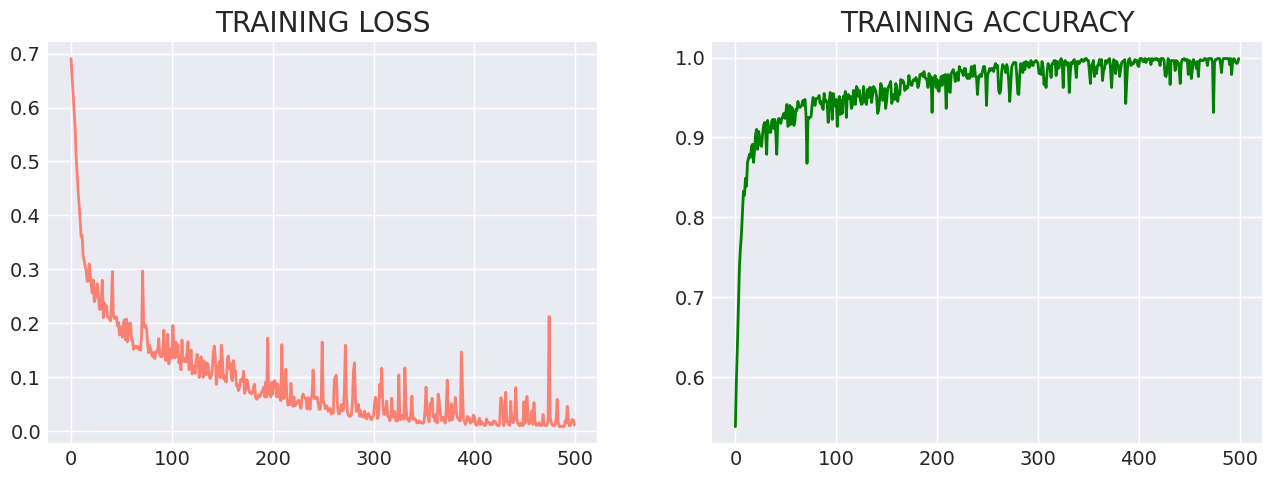

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(14,5))
ax[0].set_title('TRAINING LOSS');
ax[1].set_title('TRAINING ACCURACY');


ax[0].plot(history.history['loss'], color= 'salmon',lw=2);
ax[1].plot(history.history['accuracy'], color= 'green',lw=2);

In [ ]:
# Predict the validation data
predictions_proba = model.predict(bf_train_val)

# Apply thresholding to obtain the predicted classes
predictions = (predictions_proba > 0.5).astype(int)


7/7 [==============================] - 0s 7ms/step


In [ ]:
print(classification_report(y_val, predictions))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90        99
           1       0.89      0.92      0.90       101

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



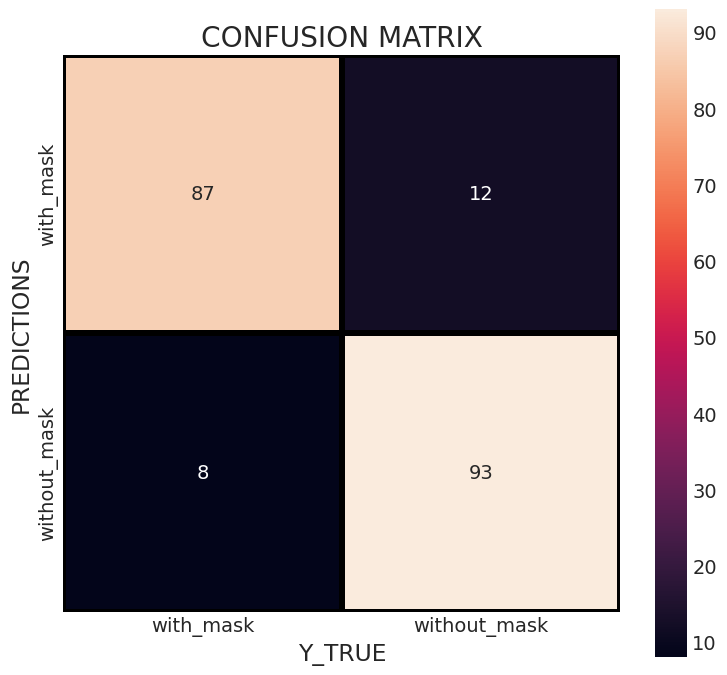

In [ ]:
con_mat = confusion_matrix(y_val, predictions)

plt.figure(figsize=(8,8))
plt.title('CONFUSION MATRIX')

sns.heatmap(con_mat,
            yticklabels=['with_mask', 'without_mask'],
            xticklabels=['with_mask', 'without_mask'],
            annot=True, linecolor='black', linewidths=4, square=True);

plt.xlabel('Y_TRUE'), plt.ylabel('PREDICTIONS');